In [1]:
import tensorflow as tf
import keras
import cv2
import numpy as np
import itertools
import os
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten,Activation,BatchNormalization

import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50,VGG16, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [2]:
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
    plt.figure(figsize=(10, 10))  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.tight_layout()        
        plt.axis('off')
        plt.imshow(img, cmap='gray') 

In [3]:
train_dir = "./archive/train/" #passing the path with training images
test_dir = "./archive/test/"  #passing the path with testing images

In [4]:
def plot_bar_chart_diagram(path_data):
  dic={}
  for emotion in  os.listdir(path_data):
    dem=0
    for x in os.listdir(path_data+"/"+emotion):
      dem+=1
    dic[emotion]=dem
  print(dic)
  barlist=plt.bar(range(len(dic)), list(dic.values()),tick_label=list(dic.keys()))
#set color
  plt.show()

{'angry': 3995, 'disgusted': 436, 'fearful': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprised': 3171}


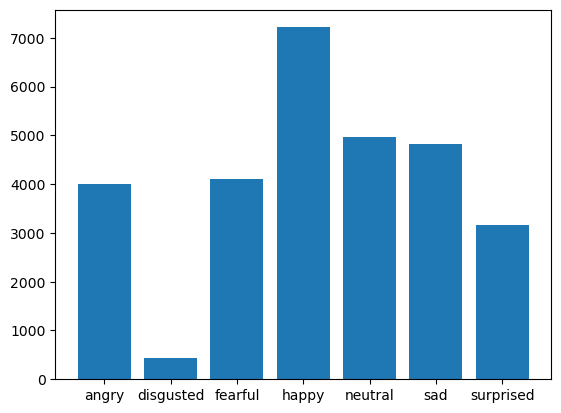

In [5]:
plot_bar_chart_diagram(train_dir)

{'angry': 958, 'disgusted': 111, 'fearful': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprised': 831}


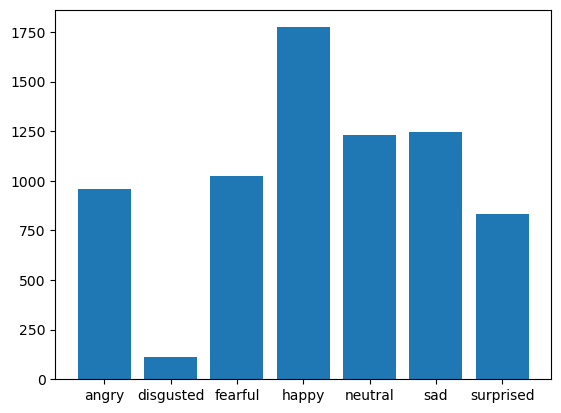

In [6]:
plot_bar_chart_diagram(test_dir)

In [7]:
img_size = 299

In [26]:
train_data_gen = ImageDataGenerator(width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255
                                         )
validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        './archive/train/',
        target_size=(299, 299),
        batch_size=16,
        class_mode='categorical')

validation_generator = validation_data_gen.flow_from_directory(
        './archive/test/',
        target_size=(299, 299),
        batch_size=16,
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [27]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(input_shape=(299,299,3),include_top = False, weights = 'imagenet')

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 305, 305, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 150, 150, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 150, 150, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [28]:
emotion_model = Sequential()
emotion_model.add(base_model)
emotion_model.add(Dropout(0.5))
emotion_model.add(Flatten())
emotion_model.add(BatchNormalization())
emotion_model.add(Dense(32,kernel_initializer='he_uniform'))
emotion_model.add(BatchNormalization())
emotion_model.add(Activation('relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(32,kernel_initializer='he_uniform'))
emotion_model.add(BatchNormalization())
emotion_model.add(Activation('relu'))
emotion_model.add(Dropout(0.5))
emotion_model.add(Dense(32,kernel_initializer='he_uniform'))
emotion_model.add(BatchNormalization())
emotion_model.add(Activation('relu'))
emotion_model.add(Dense(7,activation='softmax'))


emotion_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])


In [29]:
emotion_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 dropout_27 (Dropout)        (None, 10, 10, 2048)      0         
                                                                 
 flatten_9 (Flatten)         (None, 204800)            0         
                                                                 
 batch_normalization_36 (Ba  (None, 204800)            819200    
 tchNormalization)                                               
                                                                 
 dense_36 (Dense)            (None, 32)                6553632   
                                                                 
 batch_normalization_37 (Ba  (None, 32)                128       
 tchNormalization)                                    

In [30]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
mc = ModelCheckpoint('model_resnet.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [32]:
history = emotion_model.fit_generator(train_generator,steps_per_epoch=28709 // 16,
                                      epochs = 10,
                                      validation_data = validation_generator
                                      ,callbacks=[lrd,mc],
                                      verbose = 1,
                                      validation_steps=7178 // 16)

C:\Users\USER\AppData\Local\Temp\ipykernel_2324\965957036.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = emotion_model.fit_generator(train_generator,steps_per_epoch=28709 // 16,


Epoch 1/10
 249/1794 [===>..........................] - ETA: 2:17:31 - loss: 2.2440 - accuracy: 0.1431

KeyboardInterrupt: 